In [9]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-hold-energy-data/D202.csv
/kaggle/input/house-hold-energy-data/D202.xlsx


**Import library**

In [10]:
import tensorflow as tf 
import matplotlib.pyplot as plt

**The dataframe**

In [11]:
df= pd.read_csv("/kaggle/input/house-hold-energy-data/D202.csv")
df

,TYPE,DATE,START TIME,END TIME,USAGE,UNITS,COST,NOTES
0,Electric usage,10/22/2016,0:00,0:14,0.01,kWh,$0.00,NaN
1,Electric usage,10/22/2016,0:15,0:29,0.01,kWh,$0.00,NaN
2,Electric usage,10/22/2016,0:30,0:44,0.01,kWh,$0.00,NaN
3,Electric usage,10/22/2016,0:45,0:59,0.01,kWh,$0.00,NaN
4,Electric usage,10/22/2016,1:00,1:14,0.01,kWh,$0.00,NaN
...,...,...,...,...,...,...,...,...
70363,Electric usage,10/24/2018,22:45,22:59,0.02,kWh,$0.00,NaN
70364,Electric usage,10/24/2018,23:00,23:14,0.03,kWh,$0.01,NaN
70365,Electric usage,10/24/2018,23:15,23:29,0.03,kWh,$0.01,NaN
70366,Electric usage,10/24/2018,23:30,23:44,0.03,kWh,$0.01,NaN


In [12]:
df.dtypes

TYPE           object
DATE           object
START TIME     object
END TIME       object
USAGE         float64
UNITS          object
COST           object
NOTES         float64
dtype: object

**Change the index to date time**

In [13]:
df.index= pd.to_datetime(df['DATE'])
df

,TYPE,DATE,START TIME,END TIME,USAGE,UNITS,COST,NOTES
DATE,,,,,,,,
2016-10-22,Electric usage,10/22/2016,0:00,0:14,0.01,kWh,$0.00,NaN
2016-10-22,Electric usage,10/22/2016,0:15,0:29,0.01,kWh,$0.00,NaN
2016-10-22,Electric usage,10/22/2016,0:30,0:44,0.01,kWh,$0.00,NaN
2016-10-22,Electric usage,10/22/2016,0:45,0:59,0.01,kWh,$0.00,NaN
2016-10-22,Electric usage,10/22/2016,1:00,1:14,0.01,kWh,$0.00,NaN
...,...,...,...,...,...,...,...,...
2018-10-24,Electric usage,10/24/2018,22:45,22:59,0.02,kWh,$0.00,NaN
2018-10-24,Electric usage,10/24/2018,23:00,23:14,0.03,kWh,$0.01,NaN
2018-10-24,Electric usage,10/24/2018,23:15,23:29,0.03,kWh,$0.01,NaN


In [14]:
#dropping the notes cause only has Nan
df= df.drop(['DATE','NOTES'], axis= 1)
df

,TYPE,START TIME,END TIME,USAGE,UNITS,COST
DATE,,,,,,
2016-10-22,Electric usage,0:00,0:14,0.01,kWh,$0.00
2016-10-22,Electric usage,0:15,0:29,0.01,kWh,$0.00
2016-10-22,Electric usage,0:30,0:44,0.01,kWh,$0.00
2016-10-22,Electric usage,0:45,0:59,0.01,kWh,$0.00
2016-10-22,Electric usage,1:00,1:14,0.01,kWh,$0.00
...,...,...,...,...,...,...
2018-10-24,Electric usage,22:45,22:59,0.02,kWh,$0.00
2018-10-24,Electric usage,23:00,23:14,0.03,kWh,$0.01
2018-10-24,Electric usage,23:15,23:29,0.03,kWh,$0.01


<Axes: xlabel='DATE'>

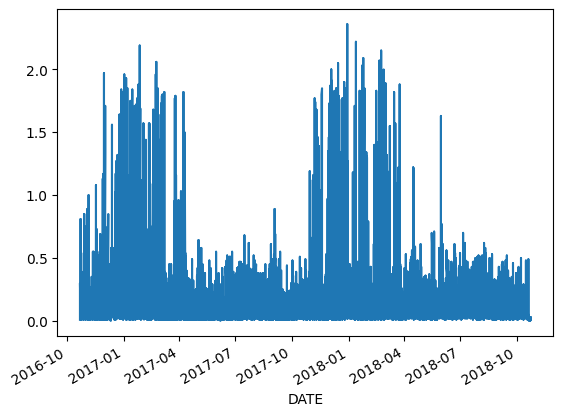

In [15]:
usage= df['USAGE']
usage.plot()

**Make function for forecasting**

In [16]:
#Example 
#[[1], [2], [3], [4], [5]] = [6]
#[[2], [3], [4], [5], [6]] = [7]
#[[3], [4], [5], [6], [7]] = [8] ....

def df_to_xy (df, window_size= 5):
    df_np = df.to_numpy() #transform the dataframe to numpy array
    X= []
    y= []
    for i in range (len(df_np)- window_size):
        row= [[a] for a in df_np[i:i+5]]
        X.append(row)
        label= df_np[i+5]
        y.append(label)
    return np.array(X), np.array(y)

**Applying the function for USAGE column**

In [17]:
WINDOW_SIZE= 5
X, y = df_to_xy(usage, WINDOW_SIZE)
X.shape, y.shape

((70363, 5, 1), (70363,))

**Splitting the data into Train, Validation, and Test**

In [18]:
X_train, y_train= X[:60000], y[:60000]
X_val, y_val= X[60000:65000], y[60000:65000]
X_test, y_test= X[65000:], y[65000:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((60000, 5, 1), (60000,), (5000, 5, 1), (5000,), (5363, 5, 1), (5363,))

**Importing the model library**

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError 
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

**Setting up the model**

In [20]:
model= Sequential()
model.add(InputLayer((5,1)))
model.add(LSTM(64))
model.add(Dense(6, 'relu'))
model.add(Dense(1, 'linear'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 6)                 390       
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 17293 (67.55 KB)
Trainable params: 17293 (67.55 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
ck_point= ModelCheckpoint('model/', save_best_only= True) #saving only the best model 

model.compile(loss= MeanSquaredError(), optimizer= Adam(learning_rate= 0.001), metrics= [RootMeanSquaredError()])

model.fit(X_train, y_train, validation_data= (X_val, y_val), epochs= 10, callbacks= [ck_point])

Epoch 1/10
1875/1875 [==============================] - 14s 6ms/step - loss: 0.0154 - root_mean_squared_error: 0.1239 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0574
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0127 - root_mean_squared_error: 0.1127 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0616
Epoch 3/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0120 - root_mean_squared_error: 0.1097 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0533
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0117 - root_mean_squared_error: 0.1081 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0536
Epoch 5/10
1875/1875 [==============================] - 10s 6ms/step - loss: 0.0115 - root_mean_squared_error: 0.1072 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0533
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0112 - root_mean_squared_error: 0.1060 - val_loss

**Load the trained model**

In [22]:
from tensorflow.keras.models import load_model 
model1= load_model('model/')

**Train data Prediction**

In [23]:
train_predict= model1.predict(X_train).flatten()
train_results= pd.DataFrame(data= {'Train Predictions': train_predict, 'Actual': y_train})
train_results

1875/1875 [==============================] - 5s 2ms/step


,Train Predictions,Actual
0,0.033764,0.01
1,0.033764,0.01
2,0.033764,0.01
3,0.033764,0.02
4,0.042212,0.02
...,...,...
59995,0.186810,0.42
59996,0.384611,0.42
59997,0.388165,0.42
59998,0.382978,0.42


**Plotting the data**

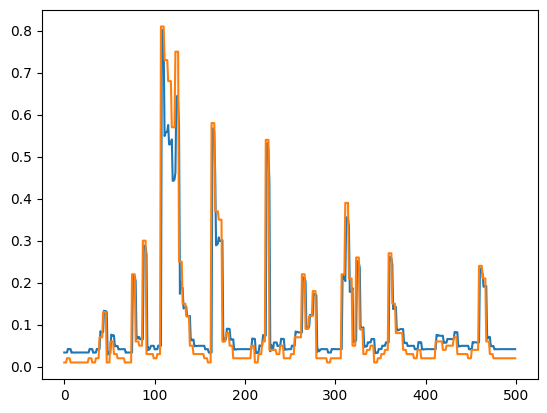

In [24]:
plt.plot(train_results['Train Predictions'][:500]) #showing 500 data 
plt.plot(train_results['Actual'][:500])
plt.show()

**Validation data Prediction**

In [25]:
val_predict= model1.predict(X_val).flatten()
val_results= pd.DataFrame(data= {'Val Predictions': val_predict, 'Actual': y_val})
val_results

157/157 [==============================] - 1s 2ms/step


,Val Predictions,Actual
0,0.345909,0.41
1,0.345732,0.41
2,0.345996,0.41
3,0.347111,0.41
4,0.347320,0.41
...,...,...
4995,0.065180,0.04
4996,0.057110,0.04
4997,0.057657,0.04
4998,0.057285,0.04


**Plotting the result**

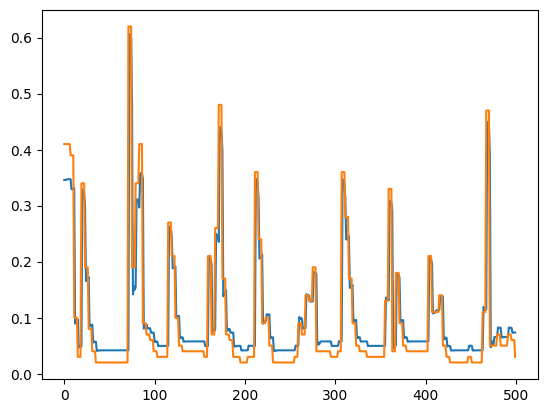

In [26]:
plt.plot(val_results['Val Predictions'][:500]) #showing 500 data 
plt.plot(val_results['Actual'][:500])
plt.show()

**Test data prediction**

In [27]:
test_predict= model1.predict(X_test).flatten()
test_results= pd.DataFrame(data= {'Test Predictions': test_predict, 'Actual': y_test})
test_results

168/168 [==============================] - 0s 2ms/step


,Test Predictions,Actual
0,0.057623,0.04
1,0.057623,0.04
2,0.057623,0.04
3,0.057623,0.04
4,0.057623,0.04
...,...,...
5358,0.041409,0.02
5359,0.041605,0.03
5360,0.050176,0.03
5361,0.049580,0.03


**Plotting the data**

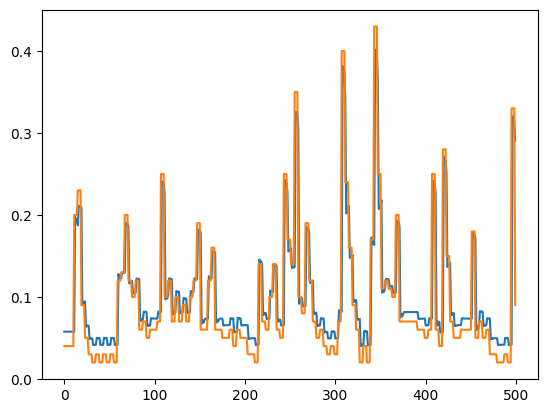

In [28]:
plt.plot(test_results['Test Predictions'][:500]) #showing 500 data 
plt.plot(test_results['Actual'][:500])
plt.show()